<a href="https://colab.research.google.com/github/DaniyalK03/HPC/blob/main/HPC_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Techniques of High-Performance Computing (Assignment 2)

**Submission by SN: 21015796**

## Introduction

The following notebook is submitted coursework for PHAS0102.

This notebook utilises the method of finite differences to solve the heat equation.


*  In **Part 1**, the time taken to do this with N increments and the associated error at each of these N values. An attempt to extrapolate to an error of $10^{-8}$ is made.

*   In **Part 2**, an attempt to model the temperature diffusivity across a metal rod heated at both ends is made. CUDA is utilised to increase the speed of this modelling by moving the arrays onto the GPU directly, which is better optimised for these calculations.

### Bibliography

**[1]** A. Al-Refaie, "Assignment 2", *PHAS0102*, 2024

## Part 1

In [ ]:
#####################################################################################################################################################

# Importing backend libraries as necessary

import numpy as np
import matplotlib.pyplot as plt
import scipy
import numba
from numba import cuda
from timeit import timeit
from scipy.sparse import coo_matrix, linalg
#from mpl_toolkits.mplot3d import Axes3D
#from matplotlib import cm
from scipy.stats import linregress

In [ ]:
def sparse_form(N):

  """
  This function takes in a number of elements and allows the wave equation problem to be converted to sparse matrix form for that number of elements.

  Inputs: N = Number of elements

  Outputs:A = Sparse matrix applied to unknowns to be found
          f = Solution matrix to allow for calculation of unknowns

  """

  # Empty arrays to hold the index and data values to form sparse matrix.
  row_ind = []
  col_ind = []
  data = []

  # Solution matrix containing N + 1 values.
  f = np.zeros(N+1)
  f[int(N)] = 1

  # Wavenumber
  k = (29 * np.pi) / 2

  # Finite differences constant
  h = 1 / N

  # Adapting code from PHAS0102 Notes [1]
  # We can reduce problem down to a single index as when j is defined without i, it equals 0
  for i in range(N+1):

    if i == 0 or i == N: # Initial boundary conditions.
      row_ind += [i]
      col_ind += [i]
      data += [1.0]

    else: # Further iterative boundary conditions.
      row_ind += [i,i,i]
      col_ind += [i,i+1,i-1]
      data += [2-(h**2)*(k**2),-1.0,-1.0]

  row_ind = np.array(row_ind)
  col_ind = np.array(col_ind)
  data = np.array(data)


  A = coo_matrix((data, (row_ind, col_ind)), shape=(N+1, N+1)).tocsr() # Converting to CSR format.

  return A, f

In [ ]:
def sparse_solve(N_array):
  """
Solves using method of finite differences using N differences.

Inputs: N_array = Array of N values equal to how many increments

Outputs:x_vals = X values along x axis
        sol_array = Array of solution values
        N_array = Same as input

  """
# Initialising arrays to be outputted.
  A_out = []
  f_out = []

  sol_array = []

  x_vals = []

  for i in N_array: # For Each N values
    output = sparse_form(i)
    A_out.append(output[0])
    f_out.append(output[1])

  for i in range(len(N_array)): # Solutions for each of these values
    sol = linalg.spsolve(A_out[i],f_out[i])
    sol_array.append(sol)

    for i in N_array:
      x = np.linspace(0 ,1, int(i+1))
      x_vals.append(x)

  return x_vals, sol_array, N_array

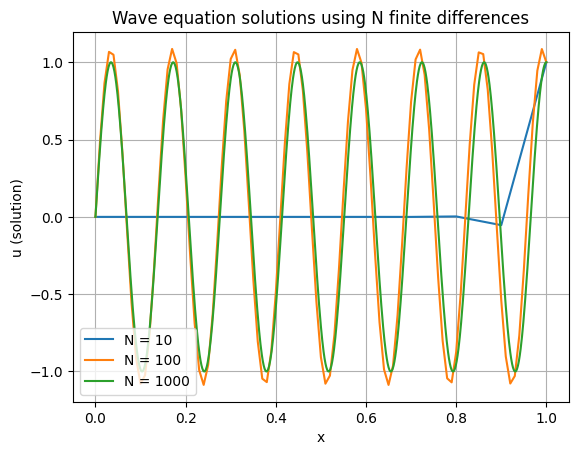

In [ ]:
x_vals, sol_array, N_array = sparse_solve([10,100,1000]) # Solving with N = 10, 100, 1000

plt.grid()
plt.title(f"Wave equation solutions using N finite differences")
plt.plot(x_vals[0], sol_array[0], "-", label=f"N = {N_array[0]}")
plt.plot(x_vals[1], sol_array[1], "-", label=f"N = {N_array[1]}")
plt.plot(x_vals[2], sol_array[2], "-", label=f"N = {N_array[2]}")
plt.xlabel("x")
plt.ylabel("u (solution)")
plt.legend(loc="lower left");

In [ ]:
def sparse_err(N_values):
  """
  This calculates the errors for each of solutions for the N values
  Inputs: N_values = Array of N values

  Outputs:errors = Errors for each of the associated N values.
  """

  x, sol, N_values = sparse_solve(N_values)

  errors = []

  k = (29 * np.pi) / 2 # k value defined from [1]

  for i in range (len(N_values)): # Comparing to the actual error values
    exact_u = np.sin(k*x[i])
    error = np.max(abs(exact_u - sol[i]))
    errors.append(error)

  return errors, N_values

In [ ]:
test_array = np.floor(np.logspace(1, 6, num=100)).astype(int) # Equally spaced for the log space of N values to be tested from N = 10 to 1000000

errors, N_values = sparse_err(test_array)

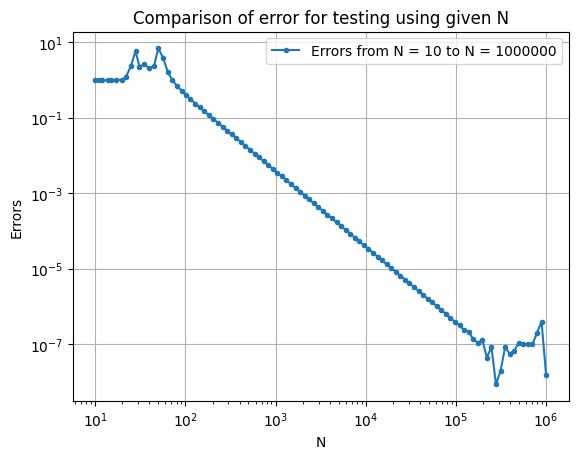

In [ ]:
plt.grid()
plt.title(f"Comparison of error for testing using given N")
plt.xscale("log")
plt.yscale("log")
plt.plot(N_values, errors, ".-", label=f"Errors from N = {N_values[0]} to N = {N_values[-1]}")
plt.xlabel("N")
plt.ylabel("Errors")
plt.legend(loc="best");

In [ ]:
def sparse_time(N_vals):

  """
  This function times the computation for each of the N values with the associated mean time taken

  Inputs: N_vals = Array of N values to be tested

  Outputs:N_vals = Same as input
          time_avg = Average time for a given N
          time_std = Std. Dev. for this time
  """

  time_avg = []
  time_std = []

  for i in N_vals:
    func_time = %timeit -o -q -n 1 -r 3 sparse_solve([i]) # Timing using a single loop over a 3 run for brevity.

    # Appending the average times per loop and standard deviations.
    time_avg.append(func_time.average)
    time_std.append(func_time.stdev)

  return(N_vals, time_avg, time_std)

In [ ]:
# Plotting and labelling the results from the timing function.

time_n, time_avg, time_std = sparse_time(test_array)


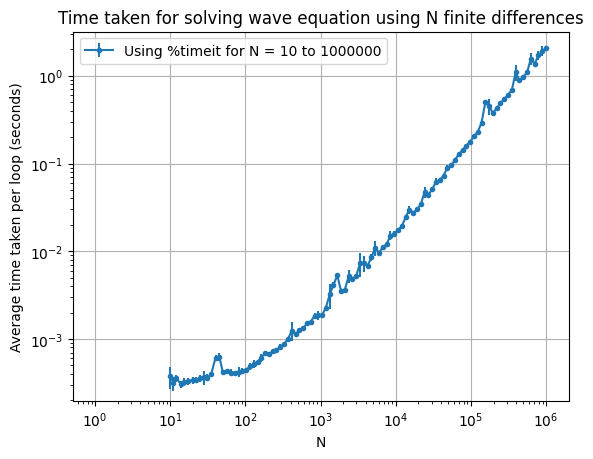

In [ ]:
plt.grid()
plt.title(f"Time taken for solving wave equation using N finite differences")
plt.xscale("log")
plt.yscale("log")
plt.errorbar(time_n, time_avg, xerr=None, yerr=time_std, fmt=".-", label=f"Using %timeit for N = {time_n[0]} to {time_n[-1]}")
plt.xlabel("N")
plt.ylabel("Average time taken per loop (seconds)")
plt.legend(loc="best");

As expected time taken increases as we increase the number of finite differences used.

In [ ]:
# Ensure N_values and errors are numpy arrays
N_values = np.array(N_values)
errors = np.array(errors)

# Step 1: Select the range for linear regression (between 10^2 and 10^5)
reduced_indices = (N_values >= 1e2) & (N_values <= 1e5)
N_reduced = N_values[reduced_indices]
errors_reduced = errors[reduced_indices]

slope, intercept, r, p, se = linregress(np.log10(N_reduced), np.log10(errors_reduced))

pred_log_vals = slope*np.log10(N_values) + intercept
pred_vals = 10 ** pred_log_vals

In [ ]:
pred_N = 10 ** ((-8 - intercept) / slope)
print(f"The extrapolated N value for an error of 10^-8 is {pred_N}")

The extrapolated N value for an error of 10^-8 is 612474.3464844432


In [ ]:
sparse_err([612474])

([2.0710402465207167e-07], [612474])

The error in reality is 2.07 x 10 ^{-7} which is greater than expected however may be attributed to interruptions to the CPU from background processes.

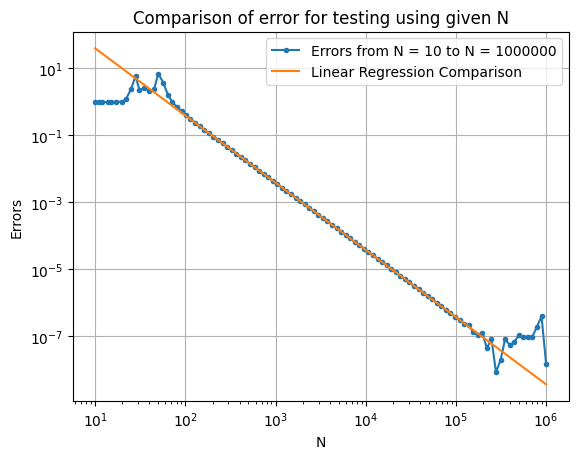

In [ ]:
# Plotting the linear extrapolation using the roughly linear middle values and the actual errors
plt.grid()
plt.title(f"Comparison of error for testing using given N")
plt.xscale("log")
plt.yscale("log")
plt.plot(N_values, errors, ".-", label=f"Errors from N = {N_values[0]} to N = {N_values[-1]}")
plt.errorbar(N_values, pred_vals, xerr=None, yerr=None, fmt="-", label=f"Linear Regression Comparison")
plt.xlabel("N")
plt.ylabel("Errors")
plt.legend(loc="best");

In [ ]:
# Ensure N_values and errors are numpy arrays
time_n = np.array(time_n)
time_avg = np.array(time_avg)

# Select the range for linear regression (between 10^2 and 10^5)
reduced_indices2 = (time_n >= 1e2) & (time_n <= 1e5)
time_n_reduced = time_n[reduced_indices2]
time_avg_reduced = time_avg[reduced_indices2]

slope2, intercept2, r2, p2, se2 = linregress(np.log10(time_n_reduced), np.log10(time_avg_reduced)) # Linear gradient and intercept values for the regression model for extrapolating.

pred_log_vals2 = slope2*np.log10(time_n) + intercept2
pred_vals2 = 10 ** pred_log_vals2

In [ ]:
pred_time = 10**(slope2 * np.log10(np.floor(pred_N)) + intercept2 )
print(pred_time)

0.7122410222502155


In [ ]:
sparse_time([612474])

([612474], [1.132626136333177], [0.01359153070361482])

In reality the timing takes longer as attributed to interrruptions to the the CPU.

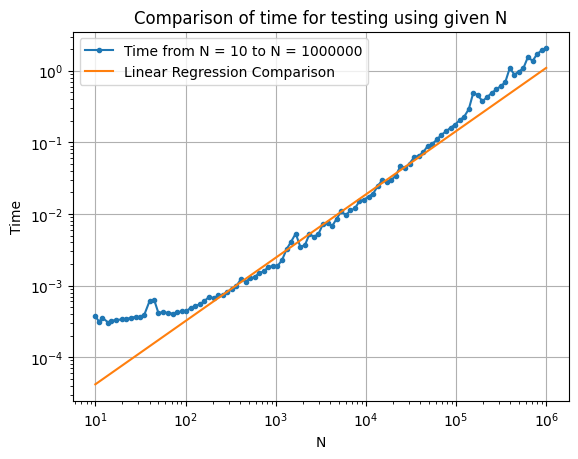

In [ ]:
plt.grid()
plt.title(f"Comparison of time for testing using given N")
plt.xscale("log")
plt.yscale("log")
plt.plot(time_n, time_avg, ".-", label=f"Time from N = {N_values[0]} to N = {N_values[-1]}")
plt.errorbar(time_n, pred_vals2, xerr=None, yerr=None, fmt="-", label=f"Linear Regression Comparison")
plt.xlabel("N")
plt.ylabel("Time")
plt.legend(loc="best");

##Part 2

In [ ]:
def heat_sol(N):
  h = 1/N
  initial_temp = 10
  timesteps = 1000*N

  u = np.zeros((timesteps + 1, N + 1))

  u[:, 0] = initial_temp # The ends stay at initial temperature throughout
  u[:, -1] = initial_temp

  for j in range(timesteps): # Updating the middle values not at the edges
    for i in range(1,N):
      u[j+1,i] = u[j, i] + ((u[j,i-1] - 2*u[j, i] + u[j, i+1]) /(1000*h))
  return u

In [ ]:
heat_N = 200
x_heat = np.linspace(0,1,heat_N+1)
u_sol = heat_sol(heat_N)

I have decided N as too small a value of N cannot accurately model the temperature change however the greater values take too long to compute therefore a midpoint of N = 200 was used.

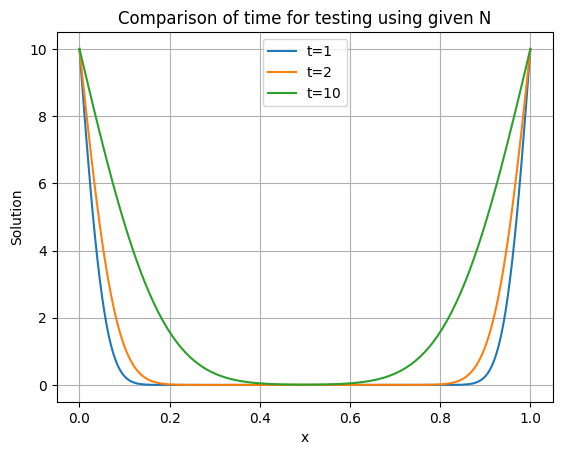

In [ ]:
plt.grid()
plt.title(f"Comparison of time for testing using given N")
plt.plot(x_heat, u_sol[heat_N], label=f"t=1")
plt.plot(x_heat, u_sol[heat_N*2], label=f"t=2")
plt.plot(x_heat, u_sol[heat_N*10], label=f"t=10")
plt.xlabel("x")
plt.ylabel("Solution")
plt.legend(loc="best");

In [ ]:
@cuda.jit # Utilising cuda to move computing onto the gpu for greater efficiency.
def heat_sol_cuda(u):

  i = cuda.grid(1)
  N = len(u)
  step = N - 1

  u[0] = 10
  u[-1] = 10

  if i==0 or i==N:
    pass
  else:
    u[i] = u[i] + (u[i+1] - 2*u[i] + u[i-1]) / (1000*step)

  return

In [ ]:
cuda_N = 200
timesteps = cuda_N*1000

u = np.zeros((cuda_N+1))

# Defining dimensions for the thread blocks.
griddim = (128,)
blockdim = (64,)

u = cuda.to_device(u)

mid_vals = []

for i in range(timesteps):
  heat_sol_cuda[griddim, blockdim](u)
  u_copy = u.copy_to_host()
  mid_vals.append(u_copy[int(cuda_N/2)])

In [ ]:
time = np.argmax(np.array(mid_vals) > 9.8)
print(time)

0


This time is incorrect however perhaps due to how efficient the timing with the GPU backend is, the timing cannot reach such a fine resolution.